# Tarea 1 Métodos Numéricos {-}

### Integrantes {-}

- Juan Diego De la Rosa
- Juan Pablo González
- Isabella Gómez
- Cristian Cortez

## Punto 1 {-}

## Punto 2 {-}

## Punto 3 {-}

## Punto 4 {-}

## Punto 5 {-}

En primer lugar se cargan los archivos de la siguiente manera

## Punto 6 {-}

In [3]:
import numpy as np

In [5]:
pts = np.loadtxt('mallas/valle_aburra-quads.pts')/1000
quads = np.loadtxt('mallas/valle_aburra-quads.quad', dtype=np.int64)

In [18]:
prim = pts[quads[0]]

In [22]:
prim[:, 0]

array([0.  , 0.  , 0.09, 0.09])

In [23]:
prim

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

In [26]:
np.array([prim[:2, 0], prim[:2, 0]])

array([[0., 0.],
       [0., 0.]])

In [38]:
prim

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

In [43]:
X = np.array(
    [[0., 0.],
     [0.09, 0.09]]
)

Y = np.array(
    [[24.39, 24.3],
     [24.39, 24.3]]
)

Z = np.array(
    [[2.519, 2.485],
     [2.548, 2.552]]
)

In [54]:
prim[:, 1].reshape(2,2)

array([[24.39, 24.3 ],
       [24.3 , 24.39]])

In [66]:
np.array([prim[:2, 1], prim[:-2, 1]])

array([[24.39, 24.3 ],
       [24.39, 24.3 ]])

In [68]:
quads

array([[    0,   173,   174,     1],
       [    1,   174,   175,     2],
       [    2,   175,   176,     3],
       ...,
       [46879, 47052, 47053, 46880],
       [46880, 47053, 47054, 46881],
       [46881, 47054, 47055, 46882]])

In [75]:
for quad in quads[:1]:
    
    points = pts[quad]
    
    X = np.array([points[:2, 0], points[:-2, 0]])
    Y = np.array([points[:2, 1], points[:-2, 1]])
    Z = np.array([points[:2, 2], points[:-2, 2]])
    
    display(X, Y, Z)

array([[0., 0.],
       [0., 0.]])

array([[24.39, 24.3 ],
       [24.39, 24.3 ]])

array([[2.519, 2.485],
       [2.519, 2.485]])

array([[0.09, 0.09],
       [0.09, 0.09]])

array([[24.39, 24.3 ],
       [24.39, 24.3 ]])

array([[2.552, 2.548],
       [2.552, 2.548]])

In [73]:
display(1)

1

<IPython.core.display.Javascript object>


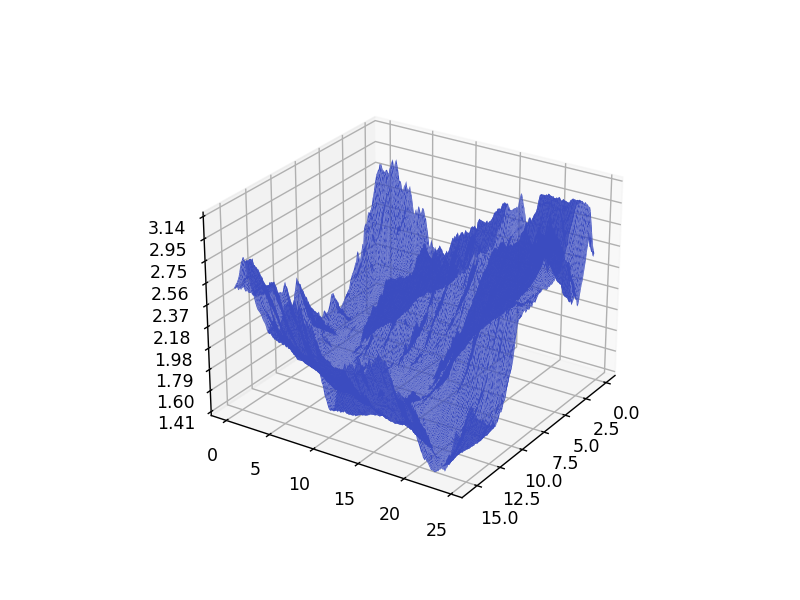

In [181]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
'''
X = np.reshape(prim[:, 0], (2,2))
Y = np.reshape(prim[:, 1], (2,2))
Z = np.reshape(prim[:, 2], (2,2))
'''

# Plot the surface.

for quad in quads:
    
    points = pts[quad]
    
    X = np.array([points[:2, 0], points[2:, 0][::-1]])
    Y = np.array([points[:2, 1], points[2:, 1][::-1]])
    Z = np.array([points[:2, 2], points[2:, 2][::-1]])

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                    linewidth=0, antialiased=True)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [182]:
15*25*2.8

1050.0

In [171]:
X = np.array([points[:2, 1], points[2:4:-1, 1]])

<ipython-input-171-74b96ebc0a0c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([points[:2, 1], points[2:4:-1, 1]])


In [166]:
points

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

In [165]:
points[:, 1]

array([24.39, 24.3 , 24.3 , 24.39])

In [121]:
points[-2:4, 0]

array([0.09, 0.09])

In [117]:
display(X, Y, Z)

array([[0., 0.],
       [0., 0.]])

array([[24.39, 24.3 ],
       [24.39, 24.3 ]])

array([[2.519, 2.485],
       [2.519, 2.485]])

In [93]:
points

array([[ 0.   , 24.39 ,  2.519],
       [ 0.   , 24.3  ,  2.485],
       [ 0.09 , 24.3  ,  2.548],
       [ 0.09 , 24.39 ,  2.552]])

In [105]:
np.array([points[:2, 1], points[-4:-2, 1]])

array([[24.39, 24.3 ],
       [24.39, 24.3 ]])

In [102]:
points[:, 1].reshape(2,2)

array([[24.39, 24.3 ],
       [24.3 , 24.39]])